In [1]:
from pathlib import Path
import random
from typing import Dict, List, Union

from cloudpathlib import S3Path
import geopandas as gpd
import pandas as pd
import rasterio

#MAIAC imports
import os
import re

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyhdf.SD import SD, SDC, SDS
import pyproj

#alignment import
from pyproj import CRS, Proj

#other imports
from pqdm.processes import pqdm

#raster transforms imports
from rasterio.transform import Affine
from rasterio.warp import reproject, Resampling

#model imports
from sklearn.ensemble import RandomForestRegressor

#MAIAC line
mpl.rcParams['figure.dpi'] = 100

#data lines
DATA_PATH = Path.cwd() / "data"
RAW = DATA_PATH / "raw"
INTERIM = DATA_PATH / "interim"

print(DATA_PATH)
print(RAW)
print(INTERIM)

C:\Users\Skyler\data
C:\Users\Skyler\data\raw
C:\Users\Skyler\data\interim


In [2]:
pm_md = pd.read_csv(
    RAW / "pm25_satellite_metadata.csv",
    parse_dates=["time_start", "time_end"],
    index_col=0
)

grid_md = pd.read_csv(
    RAW / "grid_metadata.csv",
    index_col=0
)
print(pm_md)
print(grid_md)

                                              time_start  \
granule_id                                                 
20180201T191000_maiac_la_0.hdf 2018-02-01 17:25:00+00:00   
20180202T195000_maiac_la_0.hdf 2018-02-02 18:05:00+00:00   
20180203T203000_maiac_la_0.hdf 2018-02-03 17:10:00+00:00   
20180204T194000_maiac_la_0.hdf 2018-02-04 17:55:00+00:00   
20180205T202000_maiac_la_0.hdf 2018-02-05 17:00:00+00:00   
...                                                  ...   
20210721T060842_misr_dl_0.nc   2021-07-21 05:11:48+00:00   
20210730T060258_misr_dl_0.nc   2021-07-30 05:11:45+00:00   
20210806T060933_misr_dl_0.nc   2021-08-06 05:18:20+00:00   
20210815T060400_misr_dl_0.nc   2021-08-15 05:12:45+00:00   
20210822T061044_misr_dl_0.nc   2021-08-22 05:19:30+00:00   

                                                time_end product location  \
granule_id                                                                  
20180201T191000_maiac_la_0.hdf 2018-02-01 19:10:00+00:00   maiac 

In [3]:
pm_md.columns

Index(['time_start', 'time_end', 'product', 'location', 'split', 'us_url',
       'eu_url', 'as_url', 'cksum', 'granule_size'],
      dtype='object')

In [4]:
pm_md["split"].value_counts()

train    5048
test     2673
Name: split, dtype: int64

In [5]:
pm_md["product"].value_counts()

maiac    6704
misr     1017
Name: product, dtype: int64

In [6]:
maiac_md = pm_md[(pm_md["product"] == "maiac") & (pm_md["split"] == "train")].copy()
maiac_md.shape

(4260, 10)

In [7]:
maiac_md.head(3)

,time_start,time_end,product,location,split,us_url,eu_url,as_url,cksum,granule_size
granule_id,,,,,,,,,,
20180201T191000_maiac_la_0.hdf,2018-02-01 17:25:00+00:00,2018-02-01 19:10:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,911405771,10446736
20180202T195000_maiac_la_0.hdf,2018-02-02 18:05:00+00:00,2018-02-02 19:50:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,2244451908,11090180
20180203T203000_maiac_la_0.hdf,2018-02-03 17:10:00+00:00,2018-02-03 20:30:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,3799527997,12468482


In [8]:
maiac_md.location.value_counts()

tpe    2130
la     1065
dl     1065
Name: location, dtype: int64

In [9]:
maiac_md.time_end.dt.year.value_counts()

2020    1464
2019    1460
2018    1336
Name: time_end, dtype: int64

In [10]:
maiac_md.time_end.dt.month.value_counts().sort_index()

1     248
2     340
3     372
4     360
5     372
6     360
7     372
8     372
9     360
10    372
11    360
12    372
Name: time_end, dtype: int64

In [11]:
(maiac_md.time_end - maiac_md.time_start).describe()

count                         4260
mean     0 days 01:27:16.549295774
std      0 days 00:55:30.276180728
min                0 days 00:05:00
25%                0 days 00:10:00
50%                0 days 01:45:00
75%                0 days 01:45:00
max                0 days 14:20:00
dtype: object

In [12]:
grid_md.head(3)

,location,tz,wkt
grid_id,,,
1X116,Taipei,Asia/Taipei,"POLYGON ((121.5257644471362 24.97766123020391,..."
1Z2W7,Delhi,Asia/Calcutta,"POLYGON ((77.30453178416276 28.54664454217707,..."
3S31A,Los Angeles (SoCAB),Etc/GMT+8,POLYGON ((-117.9338248256995 33.79558357488509...


In [13]:
grid_md.shape

(54, 3)

In [14]:
grid_md.location.value_counts()

Delhi                  33
Los Angeles (SoCAB)    14
Taipei                  7
Name: location, dtype: int64

In [15]:
la_file = maiac_md[maiac_md.location == "la"].iloc[0]
dl_file = maiac_md[maiac_md.location == "dl"].iloc[0]
tpe_file = maiac_md[maiac_md.location == "tpe"].iloc[0]

print(la_file)
print()
la_file_path = str(la_file['split']) + "/" + str(la_file['product']) + "/" + str(la_file['time_start'].year) + "/" + str(la_file.name)
dl_file_path = str(dl_file['split']) + "/" + str(dl_file['product']) + "/" + str(dl_file['time_start'].year) + "/" + str(dl_file.name)
tpe_file_path = str(tpe_file['split']) + "/" + str(tpe_file['product']) + "/" + str(tpe_file['time_start'].year) + "/" + str(tpe_file.name)

print(la_file_path)

time_start                              2018-02-01 17:25:00+00:00
time_end                                2018-02-01 19:10:00+00:00
product                                                     maiac
location                                                       la
split                                                       train
us_url          s3://drivendata-competition-airathon-public-us...
eu_url          s3://drivendata-competition-airathon-public-eu...
as_url          s3://drivendata-competition-airathon-public-as...
cksum                                                   911405771
granule_size                                             10446736
Name: 20180201T191000_maiac_la_0.hdf, dtype: object

train/maiac/2018/20180201T191000_maiac_la_0.hdf


In [16]:
hdf = SD(la_file_path, SDC.READ)
hdf_dl = SD(dl_file_path, SDC.READ)
hdf_tpe = SD(tpe_file_path, SDC.READ)

print(hdf.info())
print(hdf_dl.info())
print(hdf_tpe.info())

(13, 8)
(13, 8)
(13, 8)


In [17]:
for dataset, metadata in hdf.datasets().items():
    dimensions, shape, _, _ = metadata
    print(f"{dataset}\n    Dimensions: {dimensions}\n    Shape: {shape}")

Optical_Depth_047
    Dimensions: ('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km')
    Shape: (4, 1200, 1200)
Optical_Depth_055
    Dimensions: ('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km')
    Shape: (4, 1200, 1200)
AOD_Uncertainty
    Dimensions: ('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km')
    Shape: (4, 1200, 1200)
FineModeFraction
    Dimensions: ('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km')
    Shape: (4, 1200, 1200)
Column_WV
    Dimensions: ('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km')
    Shape: (4, 1200, 1200)
AOD_QA
    Dimensions: ('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km')
    Shape: (4, 1200, 1200)
AOD_MODEL
    Dimensions: ('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km')
    Shape: (4, 1200, 1200)
Injection_Height
    Dimensions: ('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km')
    Shape: (4, 1200, 1200)
cosSZA
    Dimensions: ('Orbits:grid5km', 'YDim:grid5km', 'XDim:grid5km')
    Shape: (4, 240, 240)
cosVZA
    Dimensions: ('Orbits:grid

In [18]:
blue_band_AOD = hdf.select("Optical_Depth_047")
green_band_AOD = hdf.select("Optical_Depth_055")

blue_band_AOD_dl = hdf_dl.select("Optical_Depth_047")
green_band_AOD_dl = hdf_dl.select("Optical_Depth_055")

blue_band_AOD_tpe = hdf_tpe.select("Optical_Depth_047")
green_band_AOD_tpe = hdf_tpe.select("Optical_Depth_055")

In [19]:
name1, num_dim1, shape1, types1, num_attr1 = blue_band_AOD.info()
name2, num_dim2, shape2, types2, num_attr2 = green_band_AOD.info()

print(
f"""Dataset name: {name1}
Number of dimensions: {num_dim1}
Shape: {shape1}
Data type: {types1}
Number of attributes: {num_attr1}"""
)

name1_dl, num_dim1_dl, shape1_dl, types1_dl, num_attr1_dl = blue_band_AOD_dl.info()
name2_dl, num_dim2_dl, shape2_dl, types2_dl, num_attr2_dl = green_band_AOD_dl.info()

print(
f"""Dataset name: {name1_dl}
Number of dimensions: {num_dim1_dl}
Shape: {shape1_dl}
Data type: {types1_dl}
Number of attributes: {num_attr1_dl}"""
)

name1_tpe, num_dim1_tpe, shape1_tpe, types1_tpe, num_attr1_tpe = blue_band_AOD_tpe.info()
name2_tpe, num_dim2_tpe, shape2_tpe, types2_tpe, num_attr2_tpe = green_band_AOD_tpe.info()

print(
f"""Dataset name: {name1_tpe}
Number of dimensions: {num_dim1_tpe}
Shape: {shape1_tpe}
Data type: {types1_tpe}
Number of attributes: {num_attr1_tpe}"""
)

Dataset name: Optical_Depth_047
Number of dimensions: 3
Shape: [4, 1200, 1200]
Data type: 22
Number of attributes: 6
Dataset name: Optical_Depth_047
Number of dimensions: 3
Shape: [3, 1200, 1200]
Data type: 22
Number of attributes: 6
Dataset name: Optical_Depth_047
Number of dimensions: 3
Shape: [4, 1200, 1200]
Data type: 22
Number of attributes: 6


In [20]:
blue_band_AOD.get()

array([[[-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        ...,
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672]],

       [[-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        ...,
        [    21,     21,     21, ..., -28672, -28672, -28672],
        [    22,     21,     21, ..., -28672, -28672, -28672],
        [    24,     22,     21, ..., -28672, -28672, -28672]],

       [[-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        ...,
        [   

In [21]:
calibration_dict1 = blue_band_AOD.attributes()
calibration_dict2 = green_band_AOD.attributes()

calibration_dict1_dl = blue_band_AOD_dl.attributes()
calibration_dict1_tpe = blue_band_AOD_tpe.attributes()

calibration_dict2_dl = green_band_AOD_dl.attributes()
calibration_dict2_tpe = green_band_AOD_tpe.attributes()

print(calibration_dict1)
print(calibration_dict1_dl)
print(calibration_dict1_tpe)

print(calibration_dict2)
print(calibration_dict2_dl)
print(calibration_dict2_tpe)

{'long_name': 'AOD at 0.47 micron', 'scale_factor': 0.001, 'add_offset': 0.0, 'unit': 'none', '_FillValue': -28672, 'valid_range': [-100, 5000]}
{'long_name': 'AOD at 0.47 micron', 'scale_factor': 0.001, 'add_offset': 0.0, 'unit': 'none', '_FillValue': -28672, 'valid_range': [-100, 5000]}
{'long_name': 'AOD at 0.47 micron', 'scale_factor': 0.001, 'add_offset': 0.0, 'unit': 'none', '_FillValue': -28672, 'valid_range': [-100, 5000]}
{'long_name': 'AOD at 0.55 micron', 'scale_factor': 0.001, 'add_offset': 0.0, 'unit': 'none', '_FillValue': -28672, 'valid_range': [-100, 5000]}
{'long_name': 'AOD at 0.55 micron', 'scale_factor': 0.001, 'add_offset': 0.0, 'unit': 'none', '_FillValue': -28672, 'valid_range': [-100, 5000]}
{'long_name': 'AOD at 0.55 micron', 'scale_factor': 0.001, 'add_offset': 0.0, 'unit': 'none', '_FillValue': -28672, 'valid_range': [-100, 5000]}


In [22]:
list(hdf.attributes().keys())

['HDFEOSVersion',
 'StructMetadata.0',
 'Orbit_amount',
 'Orbit_time_stamp',
 'CoreMetadata.0',
 'ArchiveMetadata.0',
 'identifier_product_doi',
 'identifier_product_doi_authority']

In [23]:
raw_attr = hdf.attributes()["StructMetadata.0"]

raw_attr_dl = hdf_dl.attributes()["StructMetadata.0"]
raw_attr_tpe = hdf_tpe.attributes()["StructMetadata.0"]

print(raw_attr)

GROUP=SwathStructure
END_GROUP=SwathStructure
GROUP=GridStructure
	GROUP=GRID_1
		GridName="grid1km"
		XDim=1200
		YDim=1200
		UpperLeftPointMtrs=(-11119505.196667,4447802.078667)
		LowerRightMtrs=(-10007554.677000,3335851.559000)
		Projection=GCTP_SNSOID
		ProjParams=(6371007.181000,0,0,0,0,0,0,0,0,0,0,0,0)
		SphereCode=-1
		GridOrigin=HDFE_GD_UL
		GROUP=Dimension
			OBJECT=Dimension_1
				DimensionName="Orbits"
				Size=4
			END_OBJECT=Dimension_1
		END_GROUP=Dimension
		GROUP=DataField
			OBJECT=DataField_1
				DataFieldName="Optical_Depth_047"
				DataType=DFNT_INT16
				DimList=("Orbits","YDim","XDim")
			END_OBJECT=DataField_1
			OBJECT=DataField_2
				DataFieldName="Optical_Depth_055"
				DataType=DFNT_INT16
				DimList=("Orbits","YDim","XDim")
			END_OBJECT=DataField_2
			OBJECT=DataField_3
				DataFieldName="AOD_Uncertainty"
				DataType=DFNT_INT16
				DimList=("Orbits","YDim","XDim")
			END_OBJECT=DataField_3
			OBJECT=DataField_4
				DataFieldName="FineModeFraction"
				Data

In [24]:
# Construct grid metadata from text blob
group_1 = raw_attr.split("END_GROUP=GRID_1")[0]
hdf_metadata = dict([x.split("=") for x in group_1.split() if "=" in x])

# Parse expressions still wrapped in apostrophes
for key, val in hdf_metadata.items():
    try:
        hdf_metadata[key] = eval(val)
    except:
        pass
    
# Construct grid metadata from text blob
group_1_dl = raw_attr_dl.split("END_GROUP=GRID_1")[0]
hdf_metadata_dl = dict([x.split("=") for x in group_1_dl.split() if "=" in x])

# Parse expressions still wrapped in apostrophes
for key, val in hdf_metadata_dl.items():
    try:
        hdf_metadata_dl[key] = eval(val)
    except:
        pass
    
# Construct grid metadata from text blob
group_1_tpe = raw_attr_tpe.split("END_GROUP=GRID_1")[0]
hdf_metadata_tpe = dict([x.split("=") for x in group_1_tpe.split() if "=" in x])

# Parse expressions still wrapped in apostrophes
for key, val in hdf_metadata_tpe.items():
    try:
        hdf_metadata_tpe[key] = eval(val)
    except:
        pass


print(hdf_metadata)
print(hdf_metadata_dl)
print(hdf_metadata_tpe)

{'GROUP': 'MergedFields', 'END_GROUP': 'MergedFields', 'GridName': 'grid1km', 'XDim': 1200, 'YDim': 1200, 'UpperLeftPointMtrs': (-11119505.196667, 4447802.078667), 'LowerRightMtrs': (-10007554.677, 3335851.559), 'Projection': 'GCTP_SNSOID', 'ProjParams': (6371007.181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), 'SphereCode': -1, 'GridOrigin': 'HDFE_GD_UL', 'OBJECT': 'DataField_8', 'DimensionName': 'Orbits', 'Size': 4, 'END_OBJECT': 'DataField_8', 'DataFieldName': 'Injection_Height', 'DataType': 'DFNT_FLOAT32', 'DimList': ('Orbits', 'YDim', 'XDim')}
{'GROUP': 'MergedFields', 'END_GROUP': 'MergedFields', 'GridName': 'grid1km', 'XDim': 1200, 'YDim': 1200, 'UpperLeftPointMtrs': (6671703.118, 3335851.559), 'LowerRightMtrs': (7783653.637667, 2223901.039333), 'Projection': 'GCTP_SNSOID', 'ProjParams': (6371007.181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), 'SphereCode': -1, 'GridOrigin': 'HDFE_GD_UL', 'OBJECT': 'DataField_8', 'DimensionName': 'Orbits', 'Size': 3, 'END_OBJECT': 'DataField_8', 'DataFieldNa

In [25]:
# Note that coordinates are provided in meters
alignment_dict = {
    "upper_left": hdf_metadata["UpperLeftPointMtrs"],
    "lower_right": hdf_metadata["LowerRightMtrs"],
    "crs": hdf_metadata["Projection"],
    "crs_params": hdf_metadata["ProjParams"]
}

alignment_dict_dl = {
    "upper_left": hdf_metadata_dl["UpperLeftPointMtrs"],
    "lower_right": hdf_metadata_dl["LowerRightMtrs"],
    "crs": hdf_metadata_dl["Projection"],
    "crs_params": hdf_metadata_dl["ProjParams"]
}

alignment_dict_tpe = {
    "upper_left": hdf_metadata_tpe["UpperLeftPointMtrs"],
    "lower_right": hdf_metadata_tpe["LowerRightMtrs"],
    "crs": hdf_metadata_tpe["Projection"],
    "crs_params": hdf_metadata_tpe["ProjParams"]
}

print(alignment_dict)
print(alignment_dict_dl)
print(alignment_dict_tpe)

{'upper_left': (-11119505.196667, 4447802.078667), 'lower_right': (-10007554.677, 3335851.559), 'crs': 'GCTP_SNSOID', 'crs_params': (6371007.181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)}
{'upper_left': (6671703.118, 3335851.559), 'lower_right': (7783653.637667, 2223901.039333), 'crs': 'GCTP_SNSOID', 'crs_params': (6371007.181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)}
{'upper_left': (12231455.716333, 3335851.559), 'lower_right': (13343406.236, 2223901.039333), 'crs': 'GCTP_SNSOID', 'crs_params': (6371007.181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)}


In [26]:
# Loop over orbits to apply the attributes
def calibrate_data(dataset: SDS, shape: List[int], calibration_dict: Dict):
    """Given a MAIAC dataset and calibration parameters, return a masked
    array of calibrated data.
    
    Args:
        dataset (SDS): dataset in SDS format (e.g. blue band AOD).
        shape (List[int]): dataset shape as a list of [orbits, height, width].
        calibration_dict (Dict): dictionary containing, at a minimum,
            `valid_range` (list or tuple), `_FillValue` (int or float),
            `add_offset` (float), and `scale_factor` (float).
    
    Returns:
        corrected_AOD (np.ma.MaskedArray): masked array of calibrated data
            with a fill value of nan.
    """
    corrected_AOD = np.ma.empty(shape, dtype=np.double)
    for orbit in range(shape[0]):
        data = dataset[orbit, :, :].astype(np.double)
        invalid_condition = (
            (data < calibration_dict["valid_range"][0]) |
            (data > calibration_dict["valid_range"][1]) |
            (data == calibration_dict["_FillValue"])
        )
        data[invalid_condition] = np.nan
        data = (
            (data - calibration_dict["add_offset"]) *
            calibration_dict["scale_factor"]
        )
        data = np.ma.masked_array(data, np.isnan(data))
        corrected_AOD[orbit, : :] = data
    corrected_AOD.fill_value = np.nan
    return corrected_AOD

In [27]:
corrected_AOD1 = calibrate_data(blue_band_AOD, shape1, calibration_dict1)
corrected_AOD2 = calibrate_data(green_band_AOD, shape2, calibration_dict2)

corrected_AOD1_dl = calibrate_data(blue_band_AOD_dl, shape1_dl, calibration_dict1)
corrected_AOD2_dl = calibrate_data(green_band_AOD_dl, shape2_dl, calibration_dict2)

corrected_AOD1_tpe = calibrate_data(blue_band_AOD_tpe, shape1_tpe, calibration_dict1)
corrected_AOD2_tpe = calibrate_data(green_band_AOD_tpe, shape2_tpe, calibration_dict2)

print(corrected_AOD1.shape)
print(corrected_AOD1_dl.shape)
print(corrected_AOD1_tpe.shape)

(4, 1200, 1200)
(3, 1200, 1200)
(4, 1200, 1200)


In [28]:
pd.DataFrame(corrected_AOD1.ravel(), columns=['AOD']).describe()
pd.DataFrame(corrected_AOD2.ravel(), columns=['AOD']).describe()

,AOD
count,1.198746e+06
mean,6.699129e-02
std,5.196741e-02
min,0.000000e+00
25%,2.900000e-02
50%,5.500000e-02
75%,9.300000e-02
max,5.650000e-01


In [29]:
#Data alignment
shape1

[4, 1200, 1200]

In [30]:
alignment_dict

{'upper_left': (-11119505.196667, 4447802.078667),
 'lower_right': (-10007554.677, 3335851.559),
 'crs': 'GCTP_SNSOID',
 'crs_params': (6371007.181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)}

In [31]:
def create_meshgrid(alignment_dict: Dict, shape: List[int]):
    """Given an image shape, create a meshgrid of points
    between bounding coordinates.
    
    Args:
        alignment_dict (Dict): dictionary containing, at a minimum,
            `upper_left` (tuple), `lower_right` (tuple), `crs` (str),
            and `crs_params` (tuple).
        shape (List[int]): dataset shape as a list of
            [orbits, height, width].
    
    Returns:
        xv (np.array): x (longitude) coordinates.
        yv (np.array): y (latitude) coordinates.
    """
    # Determine grid bounds using two coordinates
    x0, y0 = alignment_dict["upper_left"]
    x1, y1 = alignment_dict["lower_right"]
    
    # Interpolate points between corners, inclusive of bounds
    x = np.linspace(x0, x1, shape[2], endpoint=True)
    y = np.linspace(y0, y1, shape[1], endpoint=True)
    
    # Return two 2D arrays representing X & Y coordinates of all points
    xv, yv = np.meshgrid(x, y)
    return xv, yv

In [32]:
xv1, yv1 = create_meshgrid(alignment_dict, shape1)
xv2, yv2 = create_meshgrid(alignment_dict, shape2)

xv1_dl, yv1_dl = create_meshgrid(alignment_dict_dl, shape1_dl)
xv2_dl, yv2_dl = create_meshgrid(alignment_dict_dl, shape2_dl)

xv1_tpe, yv1_tpe = create_meshgrid(alignment_dict_tpe, shape1_tpe)
xv2_tpe, yv2_tpe = create_meshgrid(alignment_dict_tpe, shape2_tpe)

In [33]:
# Source: https://spatialreference.org/ref/sr-org/modis-sinusoidal/proj4js/
sinu_crs = Proj(f"+proj=sinu +R={alignment_dict['crs_params'][0]} +nadgrids=@null +wktext").crs
wgs84_crs = CRS.from_epsg("4326")

sinu_crs_dl = Proj(f"+proj=sinu +R={alignment_dict_dl['crs_params'][0]} +nadgrids=@null +wktext").crs
wgs84_crs_dl = CRS.from_epsg("4326")

sinu_crs_tpe = Proj(f"+proj=sinu +R={alignment_dict_tpe['crs_params'][0]} +nadgrids=@null +wktext").crs
wgs84_crs_tpe = CRS.from_epsg("4326")

In [34]:
def transform_arrays(
    xv: Union[np.array, float],
    yv: Union[np.array, float],
    crs_from: CRS,
    crs_to: CRS
):
    """Transform points or arrays from one CRS to another CRS.
    
    Args:
        xv (np.array or float): x (longitude) coordinates or value.
        yv (np.array or float): y (latitude) coordinates or value.
        crs_from (CRS): source coordinate reference system.
        crs_to (CRS): destination coordinate reference system.
    
    Returns:
        lon, lat (tuple): x coordinate(s), y coordinate(s)
    """
    transformer = pyproj.Transformer.from_crs(
        crs_from,
        crs_to,
        always_xy=True,
    )
    lon, lat = transformer.transform(xv, yv)
    return lon, lat

In [35]:
# Project sinu grid onto wgs84 grid
lon1, lat1 = transform_arrays(xv1, yv1, sinu_crs, wgs84_crs)
lon2, lat2 = transform_arrays(xv2, yv2, sinu_crs, wgs84_crs)

lon1_dl, lat1_dl = transform_arrays(xv1_dl, yv1_dl, sinu_crs_dl, wgs84_crs_dl)
lon2_dl, lat2_dl = transform_arrays(xv2_dl, yv2_dl, sinu_crs_dl, wgs84_crs_dl)

lon1_tpe, lat1_tpe = transform_arrays(xv1_tpe, yv1_tpe, sinu_crs_tpe, wgs84_crs_tpe)
lon2_tpe, lat2_tpe = transform_arrays(xv2_tpe, yv2_tpe, sinu_crs_tpe, wgs84_crs_tpe)

In [36]:
def convert_array_to_df(
    corrected_arr: np.ma.MaskedArray,
    lat: np.ndarray,
    lon: np.ndarray,
    granule_id: str,
    crs: CRS,
    total_bounds: np.ndarray = None
):
    """Align data values with latitude and longitude coordinates
    and return a GeoDataFrame.
    
    Args:
        corrected_arr (np.ma.MaskedArray): data values for each pixel.
        lat (np.ndarray): latitude for each pixel.
        lon (np.ndarray): longitude for each pixel.
        granule_id (str): granule name.
        crs (CRS): coordinate reference system
        total_bounds (np.ndarray, optional): If provided,
            will filter out points that fall outside of these bounds.
            Composed of xmin, ymin, xmax, ymax.
    """
    lats = lat.ravel()
    lons = lon.ravel()
    n_orbits = len(corrected_arr)
    size = lats.size
    values = {
        "value": np.concatenate([d.data.ravel() for d in corrected_arr]),
        "lat": np.tile(lats, n_orbits),
        "lon": np.tile(lons, n_orbits),
        "orbit": np.arange(n_orbits).repeat(size),
        "granule_id": [granule_id] * size * n_orbits
        
    }
    
    df = pd.DataFrame(values).dropna()
    if total_bounds is not None:
        x_min, y_min, x_max, y_max = total_bounds
        df = df[df.lon.between(x_min, x_max) & df.lat.between(y_min, y_max)]
    
    gdf = gpd.GeoDataFrame(df)
    gdf["geometry"] = gpd.points_from_xy(gdf.lon, gdf.lat)
    gdf.crs = crs
    return gdf[["granule_id", "orbit", "geometry", "value"]].reset_index(drop=True)

In [37]:
gdf1 = convert_array_to_df(corrected_AOD1, lat1, lon1, la_file.name, wgs84_crs)
gdf2 = convert_array_to_df(corrected_AOD2, lat2, lon2, la_file.name, wgs84_crs)

gdf1_dl = convert_array_to_df(corrected_AOD1_dl, lat1_dl, lon1_dl, dl_file.name, wgs84_crs_dl)
gdf2_dl = convert_array_to_df(corrected_AOD2_dl, lat2_dl, lon2_dl, dl_file.name, wgs84_crs_dl)

gdf1_tpe = convert_array_to_df(corrected_AOD1_tpe, lat1_tpe, lon1_tpe, tpe_file.name, wgs84_crs_tpe)
gdf2_tpe = convert_array_to_df(corrected_AOD2_tpe, lat2_tpe, lon2_tpe, tpe_file.name, wgs84_crs_tpe)

gdf1_tpe.head(3)

,granule_id,orbit,geometry,value
0,20180201T024000_maiac_tpe_0.hdf,0,POINT (135.49488 27.79817),0.206
1,20180201T024000_maiac_tpe_0.hdf,0,POINT (135.50431 27.79817),0.198
2,20180201T024000_maiac_tpe_0.hdf,0,POINT (135.51373 27.79817),0.198


In [38]:
print(gdf1.shape)
print(gdf1_dl.shape)
print(gdf1_tpe.shape)
gdf1.head(3)

(1203568, 4)
(2334203, 4)
(6872, 4)


,granule_id,orbit,geometry,value
0,20180201T191000_maiac_la_0.hdf,0,POINT (-110.79078 35.36280),0.110
1,20180201T191000_maiac_la_0.hdf,0,POINT (-110.78956 35.35446),0.076
2,20180201T191000_maiac_la_0.hdf,0,POINT (-110.28947 35.28774),0.112


In [39]:
def plot_gdf(gdf: gpd.GeoDataFrame, separate_bands: bool = True):
    """Plot the Point objects contained in a GeoDataFrame.
    Option to overlay bands.
    
    Args:
        gdf (gpd.GeoDataFrame): GeoDataFrame with, at a minimum,
            columns for `orbit`, `geometry`, and `value`.
        separate_bands (bool): Plot each band on its own axis.
            Defaults to True.
    
    Displays a matplotlib scatterplot.
    """
    if separate_bands:
        num_orbits = gdf.orbit.max() + 1
        f, axes = plt.subplots(
            1,
            num_orbits,
            figsize=(20, 5),
            sharex=True,
            sharey=True
        )
        for i, ax in enumerate(axes):
            gdf_orbit = gdf[gdf.orbit == i]
            img = ax.scatter(
                x=gdf_orbit.geometry.x,
                y=gdf_orbit.geometry.y,
                c=gdf_orbit.value,
                s=0.1,
                alpha=1,
                cmap="RdYlBu_r"
            )
            ax.set_title(f"Band {i + 1}", fontsize=12)
    else:
        f, ax = plt.subplots(1, 1, figsize=(4, 4))
        img = ax.scatter(
            x=gdf.geometry.x,
            y=gdf.geometry.y,
            c=gdf.value,
            s=0.15,
            alpha=1,
            cmap="RdYlBu_r"
        )
    f.colorbar(img)
    plt.suptitle("Blue Band AOD", fontsize=12)

In [ ]:
# Plot each orbit individually
plot_gdf(gdf1, separate_bands=True)
plot_gdf(gdf2, separate_bands=True)

plot_gdf(gdf1_dl, separate_bands=True)
plot_gdf(gdf2_dl, separate_bands=True)

plot_gdf(gdf1_tpe, separate_bands=True)
plot_gdf(gdf2_tpe, separate_bands=True)

In [40]:
# Identify LA granule filepaths and grid cells
temp_maiac_md = maiac_md #save for next cells

maiac_md = maiac_md[maiac_md.location == "la"]

#changed code to access internally saved files
la_fp = []
for i in range(maiac_md.shape[0]):
    la_fp.append(str(maiac_md.iloc[i]['split']) + "/" + str(maiac_md.iloc[i]['product']) + "/" + str(maiac_md.iloc[i]['time_start'].year) + "/" + str(maiac_md.iloc[i].name))
print(len(la_fp))
la_gc = grid_md[grid_md.location == "Los Angeles (SoCAB)"].copy()

# Load training labels
train_labels = pd.read_csv(RAW / "train_labels.csv", parse_dates=["datetime"])
train_labels.rename(columns={"value": "pm25"}, inplace=True)

# Confirm all LA grid cells are in our training labels
assert la_gc.index.isin(train_labels.grid_id).all()

len(la_gc)

1065


14

In [41]:
# Identify all granule filepaths and grid cells
maiac_md = temp_maiac_md[temp_maiac_md.location == "dl"]

#changed code to access internally saved files
dl_fp = []
for i in range(maiac_md.shape[0]):
    dl_fp.append(str(maiac_md.iloc[i]['split']) + "/" + str(maiac_md.iloc[i]['product']) + "/" + str(maiac_md.iloc[i]['time_start'].year) + "/" + str(maiac_md.iloc[i].name))
print(len(dl_fp))
dl_gc = grid_md[grid_md.location == "Delhi"].copy()

# Load training labels
train_labels_dl = pd.read_csv(RAW / "train_labels.csv", parse_dates=["datetime"])
train_labels_dl.rename(columns={"value": "pm25"}, inplace=True)

# Confirm all LA grid cells are in our training labels
assert dl_gc.index.isin(train_labels.grid_id).all()

len(dl_gc)

1065


33

In [42]:
# Identify all granule filepaths and grid cells
maiac_md = temp_maiac_md[temp_maiac_md.location == "tpe"]

#changed code to access internally saved files
tpe_fp = []
for i in range(maiac_md.shape[0]):
    tpe_fp.append(str(maiac_md.iloc[i]['split']) + "/" + str(maiac_md.iloc[i]['product']) + "/" + str(maiac_md.iloc[i]['time_start'].year) + "/" + str(maiac_md.iloc[i].name))
print(len(tpe_fp))
tpe_gc = grid_md[grid_md.location == "Taipei"].copy()

# Load training labels
train_labels_tpe = pd.read_csv(RAW / "train_labels.csv", parse_dates=["datetime"])
train_labels_tpe.rename(columns={"value": "pm25"}, inplace=True)

# Confirm all LA grid cells are in our training labels
assert tpe_gc.index.isin(train_labels.grid_id).all()

len(tpe_gc)

2130


7

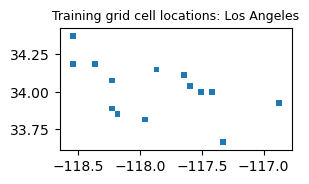

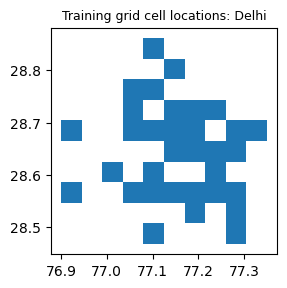

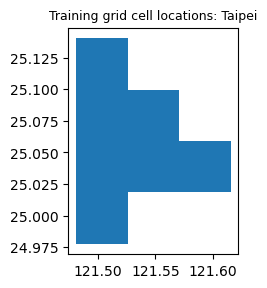

In [43]:
la_polys = gpd.GeoSeries.from_wkt(la_gc.wkt, crs=wgs84_crs) # used for WGS 84
la_polys.name = "geometry"
la_polys_gdf = gpd.GeoDataFrame(la_polys)

la_polys_gdf.plot(figsize=(3, 3)).set_title("Training grid cell locations: Los Angeles", fontsize=9);

dl_polys = gpd.GeoSeries.from_wkt(dl_gc.wkt, crs=wgs84_crs_dl) # used for WGS 84
dl_polys.name = "geometry"
dl_polys_gdf = gpd.GeoDataFrame(dl_polys)

dl_polys_gdf.plot(figsize=(3, 3)).set_title("Training grid cell locations: Delhi", fontsize=9);

tpe_polys = gpd.GeoSeries.from_wkt(tpe_gc.wkt, crs=wgs84_crs_tpe) # used for WGS 84
tpe_polys.name = "geometry"
tpe_polys_gdf = gpd.GeoDataFrame(tpe_polys)

tpe_polys_gdf.plot(figsize=(3, 3)).set_title("Training grid cell locations: Taipei", fontsize=9);

In [44]:
xmin, ymin, xmax, ymax = la_polys_gdf.total_bounds
gpd.sjoin(la_polys_gdf, gdf1.cx[xmin:xmax, ymin:ymax], how="inner").groupby("grid_id")["value"].mean()
gpd.sjoin(la_polys_gdf, gdf2.cx[xmin:xmax, ymin:ymax], how="inner").groupby("grid_id")["value"].mean()

xmin_dl, ymin_dl, xmax_dl, ymax_dl = dl_polys_gdf.total_bounds
gpd.sjoin(dl_polys_gdf, gdf1_dl.cx[xmin_dl:xmax_dl, ymin_dl:ymax_dl], how="inner").groupby("grid_id")["value"].mean()
gpd.sjoin(dl_polys_gdf, gdf2_dl.cx[xmin_dl:xmax_dl, ymin_dl:ymax_dl], how="inner").groupby("grid_id")["value"].mean()

xmin_tpe, ymin_tpe, xmax_tpe, ymax_tpe = tpe_polys_gdf.total_bounds #tpe data may have issue, no data near training grids
gpd.sjoin(tpe_polys_gdf, gdf1_tpe.cx[xmin_tpe:xmax_tpe, ymin_tpe:ymax_tpe], how="inner").groupby("grid_id")["value"].mean()
gpd.sjoin(tpe_polys_gdf, gdf2_tpe.cx[xmin_tpe:xmax_tpe, ymin_tpe:ymax_tpe], how="inner").groupby("grid_id")["value"].mean()

Series([], Name: value, dtype: float64)

In [45]:
def create_calibration_dict(data: SDS):
    """Define calibration dictionary given a SDS dataset,
    which contains:
        - name
        - scale factor
        - offset
        - unit
        - fill value
        - valid range
    
    Args:
        data (SDS): dataset in the SDS format.
    
    Returns:
        calibration_dict (Dict): dict of calibration parameters.
    """
    return data.attributes()


def create_alignment_dict(hdf: SD):
    """Define alignment dictionary given a SD data file, 
    which contains:
        - upper left coordinates
        - lower right coordinates
        - coordinate reference system (CRS)
        - CRS parameters
    
    Args:
        hdf (SD): hdf data object
    
    Returns:
        alignment_dict (Dict): dict of alignment parameters.
    """
    group_1 = hdf.attributes()["StructMetadata.0"].split("END_GROUP=GRID_1")[0]
    hdf_metadata = dict([x.split("=") for x in group_1.split() if "=" in x])
    alignment_dict = {
        "upper_left": eval(hdf_metadata["UpperLeftPointMtrs"]),
        "lower_right": eval(hdf_metadata["LowerRightMtrs"]),
        "crs": hdf_metadata["Projection"],
        "crs_params": hdf_metadata["ProjParams"]
    }
    return alignment_dict

In [46]:
def preprocess_maiac_data(
    granule_path: str,
    grid_cell_gdf: gpd.GeoDataFrame,
    dataset_name: str,
    total_bounds: np.ndarray = None
):
    """
    Given a granule s3 path and competition grid cells, 
    create a GDF of each intersecting point and the accompanying
    dataset value (e.g. blue band AOD).
    
    Args:
        granule_path (str): a path to a granule on s3.
        grid_cell_gdf (gpd.GeoDataFrame): GeoDataFrame that contains,
            at a minimum, a `grid_id` and `geometry` column of Polygons.
        dataset_name (str): specific dataset name (e.g. "Optical_Depth_047").
        total_bounds (np.ndarray, optional): If provided, will filter out points that fall
            outside of these bounds. Composed of xmin, ymin, xmax, ymax.    
    Returns:
        GeoDataFrame that contains Points and associated values.
    """
    # Load blue band AOD data
    #s3_path = S3Path(granule_path)
    #print(s3_path)
    #hdf = SD(la_file_path, SDC.READ)
    
    hdf = SD(granule_path, SDC.READ)
    #print(hdf)
    aod = hdf.select(dataset_name)
    shape = aod.info()[2]
    head, tail = os.path.split(granule_path)

    # Calibrate and align data
    calibration_dict = aod.attributes()
    alignment_dict = create_alignment_dict(hdf)
    corrected_AOD = calibrate_data(aod, shape, calibration_dict)
    xv, yv = create_meshgrid(alignment_dict, shape)
    lon, lat = transform_arrays(xv, yv, sinu_crs, wgs84_crs)

    # Save values that align with granules
    granule_gdf = convert_array_to_df(
        corrected_AOD,
        lat,
        lon,
        tail,
        wgs84_crs,
        grid_cell_gdf.total_bounds
    )
    df = gpd.sjoin(grid_cell_gdf, granule_gdf, how="inner")
    
    # Clean up files
    return df.drop(columns="index_right").reset_index()

    
def preprocess_aod_47(granule_paths, grid_cell_gdf, n_jobs=2):
    """
    Given a set of granule s3 paths and competition grid cells, 
    parallelizes creation of GDFs containing AOD 0.47 µm values and points.
    
    Args:
        granule_paths (List): list of paths on s3.
        grid_cell_gdf (gpd.GeoDataFrame): GeoDataFrame that contains,
            at a minimum, a `grid_id` and `geometry` column of Polygons.
        n_jobs (int, Optional): The number of parallel processes. Defaults to 2.
    
    Returns:
        GeoDataFrame that contains Points and associated values for all granules.
    """
    #print(granule_paths)
    args = ((gp, grid_cell_gdf, "Optical_Depth_047") for gp in granule_paths)
    #print(granule_paths)
    results = pqdm(args, preprocess_maiac_data, n_jobs=n_jobs, argument_type="args")
    #print(results)
    return pd.concat(results)

In [ ]:
frames1 = []
frames2 = []
loc_dfs1_all = []
loc_dfs2_all = []

#LA
print(len(la_fp)) #the total number of iterations
for i in range(len(la_fp)): #this step takes about 35 minutes to run
    print(i) #print current iteration
    la_train_gdf1 = pd.DataFrame(preprocess_maiac_data(la_fp[i], la_polys_gdf, "Optical_Depth_047"))
    la_train_gdf2 = pd.DataFrame(preprocess_maiac_data(la_fp[i], la_polys_gdf, "Optical_Depth_055"))
    frames1.append(la_train_gdf1)
    frames2.append(la_train_gdf2)

la_train_gdf1 = pd.concat(frames1)
la_train_gdf2 = pd.concat(frames2)
loc_dfs1_all.append(la_train_gdf1)
loc_dfs2_all.append(la_train_gdf2)
frames1 = []
frames2 = []

#DL
print(len(dl_fp)) #the total number of iterations
for i in range(len(dl_fp)): #this step takes about 35 minutes to run
    print(i) #print current iteration
    dl_train_gdf1 = pd.DataFrame(preprocess_maiac_data(dl_fp[i], dl_polys_gdf, "Optical_Depth_047"))
    dl_train_gdf2 = pd.DataFrame(preprocess_maiac_data(dl_fp[i], dl_polys_gdf, "Optical_Depth_055"))
    frames1.append(dl_train_gdf1)
    frames2.append(dl_train_gdf2)

dl_train_gdf1 = pd.concat(frames1)
dl_train_gdf2 = pd.concat(frames2)
loc_dfs1_all.append(dl_train_gdf1)
loc_dfs2_all.append(dl_train_gdf2)
frames1 = []
frames2 = []

#TPE
print(len(tpe_fp)) #the total number of iterations
for i in range(len(tpe_fp)): #this step takes about 35 minutes to run
    print(i) #print current iteration
    tpe_train_gdf1 = pd.DataFrame(preprocess_maiac_data(tpe_fp[i], tpe_polys_gdf, "Optical_Depth_047"))
    tpe_train_gdf2 = pd.DataFrame(preprocess_maiac_data(tpe_fp[i], tpe_polys_gdf, "Optical_Depth_055"))
    frames1.append(tpe_train_gdf1)
    frames2.append(tpe_train_gdf2)

tpe_train_gdf1 = pd.concat(frames1)
tpe_train_gdf2 = pd.concat(frames2)
loc_dfs1_all.append(tpe_train_gdf1)
loc_dfs2_all.append(tpe_train_gdf2)

test_df1_all = pd.concat(loc_dfs1_all)
test_df2_all = pd.concat(loc_dfs2_all)

#this saves the results to load later
%store test_df1_all
%store test_df2_all

In [47]:
%store -r test_df1_all
%store -r test_df2_all
print(test_df1_all)
print(test_df2_all)

   grid_id                                           geometry  \
0    3S31A  POLYGON ((-117.93382 33.79558, -117.93382 33.8...   
1    3S31A  POLYGON ((-117.93382 33.79558, -117.93382 33.8...   
2    3S31A  POLYGON ((-117.93382 33.79558, -117.93382 33.8...   
3    3S31A  POLYGON ((-117.93382 33.79558, -117.93382 33.8...   
4    3S31A  POLYGON ((-117.93382 33.79558, -117.93382 33.8...   
..     ...                                                ...   
31   XNLVD  POLYGON ((121.52576 25.09975, 121.52576 25.140...   
32   XNLVD  POLYGON ((121.52576 25.09975, 121.52576 25.140...   
33   XNLVD  POLYGON ((121.52576 25.09975, 121.52576 25.140...   
34   XNLVD  POLYGON ((121.52576 25.09975, 121.52576 25.140...   
35   XNLVD  POLYGON ((121.52576 25.09975, 121.52576 25.140...   

                         granule_id  orbit  value  
0    20180201T191000_maiac_la_0.hdf      2  0.093  
1    20180201T191000_maiac_la_0.hdf      1  0.074  
2    20180201T191000_maiac_la_0.hdf      1  0.067  
3    201802

In [48]:
la_train_gdf1 = test_df1_all
la_train_gdf2 = test_df2_all

print(la_train_gdf1.shape)
print(la_train_gdf2.shape)


(1110070, 5)
(1108952, 5)


In [62]:
#simple benchmark model
def calculate_features(
    feature_df: gpd.GeoDataFrame,
    label_df: pd.DataFrame,
    stage: str,
):
    """Given processed AOD data and training labels (train) or 
    submission format (test), return a feature GeoDataFrame that contains
    features for mean, max, and min AOD.
    
    Args:
        feature_df (gpd.GeoDataFrame): GeoDataFrame that contains
            Points and associated values.
        label_df (pd.DataFrame): training labels (train) or
            submission format (test).
        stage (str): "train" or "test".
    
    Returns:
        full_data (gpd.GeoDataFrame): GeoDataFrame that contains `mean_aod`,
            `max_aod`, and `min_aod` for each grid cell and datetime.   
    """
    # Add `day` column to `feature_df` and `label_df`
    feature_df["datetime"] = pd.to_datetime(
        feature_df.granule_id.str.split("_", expand=True)[0],
        format="%Y%m%dT%H:%M:%S",
        utc=True
    )
    feature_df["day"] = feature_df.datetime.dt.date
    label_df["day"] = label_df.datetime.dt.date
    
    # Calculate average AOD per day/grid cell for which we have feature data
    avg_aod_day = feature_df.groupby(["day", "grid_id"]).agg(
        {"value": ["mean", "min", "max"]}
    )
    avg_aod_day.columns = ["mean_aod", "min_aod", "max_aod"]
    avg_aod_day = avg_aod_day.reset_index()

    # Join labels/submission format with feature data
    how = "inner" if stage == "train" else "left"
    full_data = pd.merge(
        label_df,
        avg_aod_day,
        how=how,
        left_on=["day", "grid_id"],
        right_on=["day", "grid_id"]
    )
    return full_data

In [108]:
# full_data1 = calculate_features(la_train_gdf1, train_labels, stage="train")
full_data2 = calculate_features(la_train_gdf2, train_labels, stage="train")

#print(full_data1.head(3))
#print(full_data2.head(3))

full_data = pd.merge(full_data1, full_data2,  how='inner', left_on=['datetime','grid_id', 'pm25', 'day'], right_on = ['datetime','grid_id', 'pm25', 'day'])

#Skyler added features: year, month, day, hour, location (0 = LA, 1 = DL, 2 = TPE)
full_data["y"] = full_data.datetime.dt.year
full_data["m"] = full_data.datetime.dt.month
full_data["d"] = full_data.datetime.dt.day
full_data["h"] = full_data.datetime.dt.hour

locs = []
for i in range(full_data.shape[0]):
    index = grid_md.index.tolist().index(full_data["grid_id"][i])
    location = grid_md.location.tolist()[index]
    if location == 'Los Angeles (SoCAB)':
        locs.append(0)
    if location == 'Delhi':
        locs.append(1)
    if location == 'Taipei':
        locs.append(2)

full_data["locs"] = locs

full_data

,datetime,grid_id,pm25,day,mean_aod_x,min_aod_x,max_aod_x,mean_aod_y,min_aod_y,max_aod_y,y,m,d,h,locs
0,2018-02-01 08:00:00+00:00,3S31A,11.400000,2018-02-01,0.083632,0.063,0.107,0.061763,0.046,0.079,2018,2,1,8,0
1,2018-02-01 08:00:00+00:00,A2FBI,17.000000,2018-02-01,0.081053,0.059,0.106,0.059921,0.044,0.078,2018,2,1,8,0
2,2018-02-01 08:00:00+00:00,DJN0F,11.100000,2018-02-01,0.077973,0.036,0.133,0.057541,0.026,0.098,2018,2,1,8,0
3,2018-02-01 08:00:00+00:00,E5P9N,22.100000,2018-02-01,0.102154,0.052,0.161,0.075513,0.038,0.119,2018,2,1,8,0
4,2018-02-01 08:00:00+00:00,FRITQ,29.800000,2018-02-01,0.123091,0.093,0.163,0.090977,0.069,0.121,2018,2,1,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20560,2020-12-31 18:30:00+00:00,90S79,390.566667,2020-12-31,1.873667,1.739,1.963,1.525111,1.416,1.598,2020,12,31,18,1
20561,2020-12-31 18:30:00+00:00,A7UCQ,268.850548,2020-12-31,1.742870,1.685,1.885,1.418522,1.371,1.534,2020,12,31,18,1
20562,2020-12-31 18:30:00+00:00,HANW9,399.463415,2020-12-31,1.746250,1.674,1.797,1.421250,1.363,1.462,2020,12,31,18,1
20563,2020-12-31 18:30:00+00:00,IUMEZ,529.604348,2020-12-31,1.954077,1.741,2.144,1.594538,1.417,1.756,2020,12,31,18,1


In [109]:
# 2020 data will be held out for validation
train = full_data[full_data.datetime.dt.year <= 2019].copy()
test = full_data[full_data.datetime.dt.year > 2019].copy()

In [110]:
# Train model on train set
model = RandomForestRegressor()
model.fit(train[["mean_aod_x", "min_aod_x", "max_aod_x", "mean_aod_y", "min_aod_y", "max_aod_y", "y", "m", "d", "h", "locs"]], train.pm25)

# Compute R2 using our holdout set
model.score(test[["mean_aod_x", "min_aod_x", "max_aod_x", "mean_aod_y", "min_aod_y", "max_aod_y", "y", "m", "d", "h", "locs"]], test.pm25)

0.3715392552002518

In [111]:
# Refit model on entire training set
model.fit(full_data[["mean_aod_x", "min_aod_x", "max_aod_x", "mean_aod_y", "min_aod_y", "max_aod_y", "y", "m", "d", "h", "locs"]], full_data.pm25)

RandomForestRegressor()

In [112]:
# Identify test granule s3 paths
test_md = pm_md[(pm_md["product"] == "maiac") & (pm_md["split"] == "test")]

# Identify test grid cells
submission_format = pd.read_csv(RAW / "submission_format.csv", parse_dates=["datetime"])
test_gc = grid_md[grid_md.index.isin(submission_format.grid_id)]

# Process test data for each location
locations = test_gc.location.unique()
loc_map = {"Delhi": "dl", "Los Angeles (SoCAB)": "la", "Taipei": "tpe"}

In [ ]:
loc_dfs1 = []
loc_dfs2 = []

for loc in locations:
    print(loc)
    these_md = test_md[test_md.location == loc_map[loc]]
    
    #changed code to access internally saved files
    these_fp = []
    for i in range(these_md.shape[0]):
        these_fp.append(str(these_md.iloc[i]['split']) + "/" + str(these_md.iloc[i]['product']) + "/" + str(these_md.iloc[i]['time_start'].year) + "/" + str(these_md.iloc[i].name))
    
    # Create grid cell GeoDataFrame
    these_grid_cells = test_gc[test_gc.location == loc]
    these_polys = gpd.GeoSeries.from_wkt(these_grid_cells.wkt, crs=wgs84_crs)
    these_polys.name = "geometry"
    this_polys_gdf = gpd.GeoDataFrame(these_polys)

    # Preprocess AOD for test granules
    
    #Skyler code replaces this
    #result = preprocess_aod_47(these_fp, this_polys_gdf)
    frames1 = []
    frames2 = []
    print(len(these_fp)) #the total number of iterations
    for i in range(len(these_fp)): #this step takes about 35 minutes to run
        print(i) #print current iteration
        train_gdf1 = pd.DataFrame(preprocess_maiac_data(these_fp[i], this_polys_gdf, "Optical_Depth_047"))
        train_gdf2 = pd.DataFrame(preprocess_maiac_data(these_fp[i], this_polys_gdf, "Optical_Depth_055"))
        frames1.append(train_gdf1)
        frames2.append(train_gdf2)
        
    train_gdf1 = pd.concat(frames1)
    train_gdf2 = pd.concat(frames2)
    loc_dfs1.append(train_gdf1)
    loc_dfs2.append(train_gdf2)

test_df1 = pd.concat(loc_dfs1)
test_df2 = pd.concat(loc_dfs2)
    
#%store test_df1
#%store test_df2

In [113]:
%store -r test_df1
%store -r test_df2
test_df1.head(3)

# Prepare AOD features, only do once per kernel execution
submission_df1 = calculate_features(test_df1, submission_format, stage="test")
submission_df2 = calculate_features(test_df2, submission_format, stage="test")

# Impute missing features using training set mean/max/min
submission_df1.mean_aod.fillna(la_train_gdf1.value.mean(), inplace=True)
submission_df1.min_aod.fillna(la_train_gdf1.value.min(), inplace=True)
submission_df1.max_aod.fillna(la_train_gdf1.value.max(), inplace=True)
submission_df1.drop(columns=["day"], inplace=True)

submission_df2.mean_aod.fillna(la_train_gdf2.value.mean(), inplace=True)
submission_df2.min_aod.fillna(la_train_gdf2.value.min(), inplace=True)
submission_df2.max_aod.fillna(la_train_gdf2.value.max(), inplace=True)
submission_df2.drop(columns=["day"], inplace=True)

In [115]:
print(submission_df1.shape)
print(submission_df2.shape)

submission_df = pd.merge(submission_df1, submission_df2,  how='inner', left_on=['datetime','grid_id', 'value'], right_on = ['datetime','grid_id', 'value'])
print(submission_df.shape)
print(submission_df)

#add same features as training here:
submission_df["y"] = submission_df.datetime.dt.year
submission_df["m"] = submission_df.datetime.dt.month
submission_df["d"] = submission_df.datetime.dt.day
submission_df["h"] = submission_df.datetime.dt.hour

locs = []
for i in range(submission_df.shape[0]):
    index = grid_md.index.tolist().index(submission_df["grid_id"][i])
    location = grid_md.location.tolist()[index]
    if location == 'Los Angeles (SoCAB)':
        locs.append(0)
    if location == 'Delhi':
        locs.append(1)
    if location == 'Taipei':
        locs.append(2)

submission_df["locs"] = locs

# Make predictions using AOD features
submission_df["preds"] = model.predict(submission_df[["mean_aod_x", "min_aod_x", "max_aod_x", "mean_aod_y", "min_aod_y", "max_aod_y", "y", "m", "d", "h", "locs"]])
submission = submission_df[["datetime", "grid_id", "preds"]].copy()
submission.rename(columns={"preds": "value"}, inplace=True)

# Ensure submission indices match submission format
submission_format.set_index(["datetime", "grid_id"], inplace=True)
submission.set_index(["datetime", "grid_id"], inplace=True)
assert submission_format.index.equals(submission.index)

(13504, 6)
(13504, 6)
(13504, 9)
                       datetime grid_id  value  mean_aod_x  min_aod_x  \
0     2017-01-07 16:00:00+00:00   1X116    0.0    0.568494      0.000   
1     2017-01-07 16:00:00+00:00   9Q6TA    0.0    0.568494      0.000   
2     2017-01-07 16:00:00+00:00   KW43U    0.0    0.568494      0.000   
3     2017-01-07 16:00:00+00:00   VR4WG    0.0    0.594000      0.594   
4     2017-01-07 16:00:00+00:00   XJF9O    0.0    0.568494      0.000   
...                         ...     ...    ...         ...        ...   
13499 2021-08-24 08:00:00+00:00   QJHW4    0.0    0.568494      0.000   
13500 2021-08-24 08:00:00+00:00   VBLD0    0.0    0.568494      0.000   
13501 2021-08-24 08:00:00+00:00   WT52R    0.0    0.568494      0.000   
13502 2021-08-24 08:00:00+00:00   ZP1FZ    0.0    0.568494      0.000   
13503 2021-08-24 08:00:00+00:00   ZZ8JF    0.0    0.568494      0.000   

       max_aod_x  mean_aod_y  min_aod_y  max_aod_y  
0          4.000    0.454115      0.0

In [116]:
submission.head(3)

value
datetime                  grid_id           
2017-01-07 16:00:00+00:00 1X116    21.740811
                          9Q6TA    21.740811
                          KW43U    21.740811

In [117]:
submission.describe()

,value
count,13504.000000
mean,47.661433
std,59.207961
min,2.729544
25%,13.514683
50%,19.968331
75%,56.914727
max,464.465656


In [118]:
# Save submission in the correct format
final_submission = pd.read_csv(RAW / "submission_format.csv")
final_submission["value"] = submission.reset_index().value
final_submission.to_csv((INTERIM / "submission.csv"), index=False)